# Introduction

I think we can all agree that Pandas ([Pan(el) da(ta)](https://en.wikipedia.org/wiki/Panel_data)s) is our primary tool for exploring data. With tabular data, if you can conjure some transformation in your mind, you can do it in Pandas. But, with more complicated transformations, you may need to break the problem down into parts (investigate as you go), and write the Pandas calls to accomplish those parts. Once you have a first go-around at a Pandas call, your motto should be **there is always an easier way**.

For this workshop, we'll go over a few of the lesser used Pandas methods, and try to address easier ways of doing things. I assume that you are familiar with Pandas syntax (e.g., series, data frames, indices, `groupby`, etc.), and some basic Python functionality (e.g., user-defined and lambda functions, lists/arrays, etc.). I'll also assume that you understand all the basic tools of Pandas (e.g., `.head()`, `df[..]` syntax, etc.). This notebook will attempt to cover the lesser known methods of:

1. [Reading in Data](#Reading-in-Data)
2. [Describing Data](#Describing-Data)
3. [Transforming Data](#Transforming-Data)
4. [Logic, with Pandas and Numpy](#Logic,-with-Pandas-and-Numpy)
5. [Plotting Data](#Plotting-Data)

For this workshop, we'll work with the MTA data from the last month (September), along with some other data I'll make up :).

In [1]:
import pandas as pd
import pandas_profiling as pdf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
%matplotlib inline

# These are just some settings that I personally prefer when using Seaborn
# For some reason, Seaborn hates me and won't give me the nice white lines between bars in histograms, so I use these settings
sns.set_style('darkgrid')
sns.set(rc={'patch.edgecolor': 'w', 'patch.force_edgecolor': True, 'patch.linewidth': 1})

In [2]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [180901, 180908, 180915, 180922, 180929]
turnstiles = get_data(week_nums)
# If you recall, there is a column name ('EXITS', in particular) with many spaces before the string of interest actually begins. So, we strip it.
# Notice, this is a way to rename the columns (in full)
turnstiles.columns = [s.strip() for s in turnstiles.columns]
turnstiles['TURNSTILE'] = turnstiles['STATION'] + '--' + turnstiles['C/A'] + '--' + turnstiles['UNIT'] + '--' + turnstiles['SCP'] + '--' + turnstiles['LINENAME']

stations = pd.read_json('https://raw.githubusercontent.com/tmrudick/mta-turnstiles/master/data/stations.json')
stations = stations.transpose().reset_index()
stations.rename(columns={'index': 'UNIT'}, inplace=True)

# Some of the stations are new, so they were not included in the data collected by tmrudick when he/she did
append_ = pd.DataFrame({'Unit': ['R072', 'R570', 'R571', 'R572'], 
                        'latitude': ['40.753704', '40.768655', '40.777880', '40.785850'],
                        'line': ['7', 'QR', 'NQR', 'NQR'],
                        'longitude': ['-74.002236', '-73.958427', '-73.951473', '-73.950944'],
                        'station': ['34 ST-HUDSON YD', '72 ST-2 AVE', '86 ST-2 AVE', '96 ST-2 AVE'],
                        'Station_Unit': ['34 ST-HUDSON YD R072', '72 ST-2 AVE R570', '86 ST-2 AVE R571', '96 ST-2 AVE R572']
                        })
stations = stations.append(append_, ignore_index=True)

In [3]:
turnstiles.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TURNSTILE
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,00:00:00,REGULAR,6736067,2283184,59 ST--A002--R051--02-00-00--NQR456W
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,04:00:00,REGULAR,6736087,2283188,59 ST--A002--R051--02-00-00--NQR456W
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,08:00:00,REGULAR,6736105,2283229,59 ST--A002--R051--02-00-00--NQR456W
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,12:00:00,REGULAR,6736180,2283314,59 ST--A002--R051--02-00-00--NQR456W
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,16:00:00,REGULAR,6736349,2283384,59 ST--A002--R051--02-00-00--NQR456W


In [4]:
stations.head()

,Station_Unit,UNIT,Unit,latitude,line,longitude,station
0,NaN,R001,NaN,40.703082,R1,-74.012983,SOUTH FERRY
1,NaN,R002,NaN,40.709938,ACJZ2345,-74.007983,FULTON ST
2,NaN,R003,NaN,40.689945,J,-73.872564,CYPRESS HILLS
3,NaN,R004,NaN,40.69132,JZ,-73.867135,ELDERTS LANE
4,NaN,R005,NaN,40.692304,J,-73.860151,FOREST PARKWAY


# Reading in Data

You should be familiar with the `read_csv`, or `read_json` functionality in Pandas, so we'll talk about the nuances of data-reading methods such as these, and a few other lesser used methods.

## Options for 'read_' (not datetime related)

Take some time to go through all the [parameters](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) you can change for `read_csv` (these parameters are mostly shared among the `read_...`-type calls in Pandas). **There is a lot here**, and it would behoove everyone to take a look through the list. Often, we come accross issues in the data that could have been fixed at import time. Let's go over a few:

1. `compression : {‘infer’, ‘gzip’, ‘bz2’, ‘zip’, ‘xz’, None}, default ‘infer’` --> Pandas will deal with compressed files on its own, whether you dictate which kind, or if you let it infer (by default, it will infer). If using '.zip' files, the folder must contain only one csv file (if using other compression standards, I believe this will work even if the folder contains multiple files of the same format).
2. `na_values : scalar, str, list-like, or dict, default None` --> Don't forget, sometimes, there will be NA values in the data that are not recognized by Pandas (like, '-', or something). You can provide a list of values/strings that you know count as NA, so Pandas can parse correctly.
3. `true_values : list, default None` and `false_values : list, default None` --> Similar to above, you can give a list of values/strings that you want to encode as `True` or `False`.
4. `delim_whitespace : boolean, default False` --> Supposing you have a file of strings where each of the strings have an equal number of spaces between the values, you can use this (set to True) in conjunction with `columns` or `names` (give the columns, among spaces, names) to define your data.

## Managing Datetime Using 'read_[...]'

Parsing datetime at import time really requires you to know ahead of time that there are date/datetime strings in your data, and where they are. If you do know the nature of these data, you can use these methods to read in your data properly. _Note, often it is quicker to read in datetime at the start, rather than doing it after the fact._

1. `parse_dates : boolean or list of ints or names or list of lists or dict, default False` --> First, you need to let Pandas know that it needs to parse some dates (here, you can tell it where to find the datetimes in question in a list of column indices or names). From the beginning, it will not, and will treat datetime-type things as just strings.
2. `infer_datetime_format : boolean, default False` --> Next, you have the option to let Pandas figure out what the best formatting is for the string you pass to it OR
3. `date_parser : function, default None (dateutil.parser.parser)` --> You can use some userdefined function to determine the datetime. This can get kinda hairy, so I won't go through using it. But, you can reference [this](https://stackoverflow.com/questions/42736986/pandas-date-parser-function-for-yeardoysod-format) StackOverflow post as a reference.
4. `dayfirst : boolean, default False` --> Sometimes (e.g., in the EU), the datetime in the data has the month after the day ("DD/MM"). Default is the opposite, though.

In [5]:
csv_file = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_180929.txt"

### Method 1: Parse individual columns on their own

In [6]:
# Key thing here: Make sure that the column names in `parse_dates` is in a list (even if just one)
# You'll notice below, Pandas does not keep the original data, and just completely changes it to datetime objects with the same column name
df = pd.read_csv(csv_file, parse_dates=['DATE'], infer_datetime_format=True)

In [7]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,00:00:00,REGULAR,6767488,2294227
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,04:00:00,REGULAR,6767499,2294230
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,08:00:00,REGULAR,6767517,2294258
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,12:00:00,REGULAR,6767607,2294323
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,16:00:00,REGULAR,6767790,2294368


In [8]:
type(df.DATE.iloc[0])

pandas._libs.tslib.Timestamp

In [9]:
# The only column that Pandas is going to look at is the one that you include in `parse_dates`
type(df.TIME.iloc[0])

str

It's true this can take sometimes take a while, depending on the format of the data (Pandas needs to first figure out what the date looks like). But, most of the time the date format is pretty common (like the above), so it's okay to use. But if the format is strange, you can read in the data first, then provide a [format](https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior):

### Method 2: Parse after reading in data

In [10]:
df = pd.read_csv(csv_file)
df['Datetime'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y') # As a side note, a common full date-time format is '%m/%d/%Y %H:%M:%S'

In [11]:
type(df['Datetime'].iloc[0])

pandas._libs.tslib.Timestamp

### Method 3: Parse multiple columns as one

In [12]:
# When you do this, Pandas will get rid of the original columns, join the names with a _, and make a new one. If you want to keep them, use `keep_date_col=True`
# **THIS READS THE COLUMNS IN ORDER, AND PLACES A SPACE BETWEEN THEM**. So below, it sees DATE then TIME, then parses.
df = pd.read_csv(csv_file, parse_dates=[['DATE', 'TIME']], infer_datetime_format=True)

In [13]:
df.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS
0,2018-09-22 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6767488,2294227
1,2018-09-22 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6767499,2294230
2,2018-09-22 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6767517,2294258
3,2018-09-22 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6767607,2294323
4,2018-09-22 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6767790,2294368


In [14]:
# You can rename the column using dictionary notation
df = pd.read_csv(csv_file, parse_dates={'Datetime': ['DATE', 'TIME']}, infer_datetime_format=True)
df.head()

,Datetime,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS
0,2018-09-22 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6767488,2294227
1,2018-09-22 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6767499,2294230
2,2018-09-22 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6767517,2294258
3,2018-09-22 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6767607,2294323
4,2018-09-22 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6767790,2294368


## From Numpy Array or Dict
There are a few ways that Pandas can read in data from Numpy or a dictionary:

### Numpy

In [15]:
data = np.array([[1, 2, 3],
                 [4, 5, 6],
                 [7, 8, 9]])

names = ['col1', 'col2', 'col3']

df = pd.DataFrame(data=data, columns=names)    # There are many other options in here you could use ...

In [16]:
df.head()

,col1,col2,col3
0,1,2,3
1,4,5,6
2,7,8,9


### One Dictionary

In [17]:
# Method 1: 

data = {'col1': [1, 2, 3], 'col2': [4, 5, 6], 'col3': [7, 8, 9]}    # Remember, the length of the lists here need to be EQUAL among all columns
df = pd.DataFrame(data)
df.head()

,col1,col2,col3
0,1,4,7
1,2,5,8
2,3,6,9


### List of Dictionaries

In [18]:
rows = []
for i in range(1, 4):
    row = {'col1': i, 'col2': 2*i, 'col3': 3*i}
    rows.append(row)
rows

[{'col1': 1, 'col2': 2, 'col3': 3},
 {'col1': 2, 'col2': 4, 'col3': 6},
 {'col1': 3, 'col2': 6, 'col3': 9}]

In [19]:
df = pd.DataFrame(rows)
df.head()

,col1,col2,col3
0,1,2,3
1,2,4,6
2,3,6,9


The important thing with this method is that the column names need to be shared among all dictionaries in the list.

# Describing Data

## pandas-profiling
You should all be familiar with `df.describe` or `df['col'].describe`, and things like `df['col'].std()` or `df['col'].value_counts()`. But you may not be as familiar with pandas-profiling! [Check it out](https://github.com/pandas-profiling/pandas-profiling).

Below, there's a lot of information, and often a simple `.describe` will do the trick. But, if you like, the profiler gives you a lot of information about missing values, correlations, etc.

In [20]:
turnstiles.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'TURNSTILE'],
      dtype='object')

In [21]:
turnstiles.describe()

,ENTRIES,EXITS
count,9.904250e+05,9.904250e+05
mean,3.954847e+07,3.227240e+07
std,2.049939e+08,1.892650e+08
min,0.000000e+00,0.000000e+00
25%,4.837950e+05,2.287250e+05
50%,2.460858e+06,1.378020e+06
75%,6.924419e+06,4.761935e+06
max,2.129771e+09,2.062565e+09


In [22]:
turnstiles['STATION'].value_counts().head()   # The good thing is that this will include a report on NA values!

34 ST-PENN STA     20766
FULTON ST          20262
GRD CNTRL-42 ST    13776
CORTLANDT ST       13192
23 ST              12888
Name: STATION, dtype: int64

In [23]:
pdf.ProfileReport(turnstiles[['ENTRIES', 'EXITS']])

Number of variables,3
Number of observations,990425
Total Missing (%),0.0%
Total size in memory,22.7 MiB
Average record size in memory,24.0 B
Numeric,3
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


# Transforming Data

## General Rule
Again, remember the motto **there is always a simpler way**. Before you start trying to do a bunch of stuff to a dataframe, make sure you've done all your research on StackOverflow and other forums for the shortest solution (there's a balance, though, between code simplicity and CPU usage/script efficiency -- be careful). Likely, you just need to make particular adjustments to parameters in a method.

## A Few Handy Transformations

Code | Transformation
--- | ---
`df.transpose()` | Self explanatory. Returns a dataframe, and the indices become the columns.
`df.drop('col', inplace=True, axis=1)` | Drop the column 'col' from the data frame 'df'. Works in place.
`df.rename(columns={'column1': 'col'})` | Changes the name of 'column1' to 'col'

## Dropping Duplicates (Subsetting)
Sometimes, you may want to drop duplicates, but only in a certain column (or, if there is a sort of 'vertical slice' of the data which you don't want duplicates in).

In [24]:
# What is the percentage of duplicate rows? This counts the number and percentage of rows with duplicate sub-rows among the column slice
dup = turnstiles.shape[0] - turnstiles.drop_duplicates(subset=['TURNSTILE', 'DATE', 'TIME']).shape[0]
perc = dup / turnstiles.shape[0] * 100
print(f'Percent: {np.round(perc, 4)} %')
print('Count:', dup)

Percent: 0.00020193 %
Count: 2


In [25]:
# This will actually drop them from the data frame
turnstiles.drop_duplicates(subset=['TURNSTILE', 'DATE', 'TIME'], inplace=True)

## reindex vs reset_index
More often than not, what you want is `reset_index`. In this case, you're taking the current index, and replacing it with a range from `0` to `df.shape[0]`.

In [26]:
df = pd.DataFrame([('bird',    389.0),
                   ('bird',     24.0),
                   ('mammal',   80.5),
                   ('mammal', np.nan)],
                  index=['falcon', 'parrot', 'lion', 'monkey'],
                  columns=('class', 'max_speed'))
df

,class,max_speed
falcon,bird,389.0
parrot,bird,24.0
lion,mammal,80.5
monkey,mammal,NaN


In [27]:
# Notice that it adds the original indices to a column named 'index' (we change the name from 'index' to 'name')
df.reset_index(inplace=True)
df.rename(columns={'index':'name'}, inplace=True)
df

,name,class,max_speed
0,falcon,bird,389.0
1,parrot,bird,24.0
2,lion,mammal,80.5
3,monkey,mammal,NaN


Alternatively, if you want to take only specific rows from a data frame (maybe to match something you're merging with), use `.reindex`. You can use it to subset your data, or you can use it to match some other data frame. You could also just reindex to a column of the dataframe (reversing what we did above).

In [28]:
df.reindex([0, 2, 3, 5])   # If you want to use a column as the index, use df.reindex(df['col']), then you can drop it later

,name,class,max_speed
0,falcon,bird,389.0
2,lion,mammal,80.5
3,monkey,mammal,NaN
5,NaN,NaN,NaN


## append and shift (and a bit of Regular Expressions)

For this, let's work with the Box Office Mojo Data, to get an idea for what's going on.

In [29]:
url = 'https://raw.githubusercontent.com/thisismetis/nyc18_ds16/master/challenges/challenges_data/2013_movies.csv?token=AZ_BKWb8c-QcU57rpM_nUoJq8NGH6DmVks5bvLf8wA%3D%3D'
mojo = pd.read_csv(url, parse_dates=['ReleaseDate'], infer_datetime_format=True)

In [30]:
mojo.head()

,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate
0,The Hunger Games: Catching Fire,130000000.0,424668047,Francis Lawrence,PG-13,146,2013-11-22
1,Iron Man 3,200000000.0,409013994,Shane Black,PG-13,129,2013-05-03
2,Frozen,150000000.0,400738009,Chris BuckJennifer Lee,PG,108,2013-11-22
3,Despicable Me 2,76000000.0,368061265,Pierre CoffinChris Renaud,PG,98,2013-07-03
4,Man of Steel,225000000.0,291045518,Zack Snyder,PG-13,143,2013-06-14


We're going to work through the problem of fixing multiple directors in the same cell ... This will show an example of both `append` and `shift`. As we go through, I use Regular Expressions. I highly recommend you check out [regex101](https://regex101.com/) as a tool for determining if you've written your regex patterns correctly.

In [31]:
# pdf.ProfileReport(mojo)

If you run a quick ProfileReport, you'll find that there are some NA values for Director. Since that's not a whole lot of our data set, we can be okay with dropping them from our dataframe. (You also find the same for Budget, so we can drop those, too).

In [32]:
mojo.dropna(subset=['Director', 'Budget'], inplace=True)

In [33]:
import re

def get_dir2(director):    # 'director' is one single value from a pd.Series of rows (we iterate down rows)
    
    # Match strings containing a lowercase next to an upper case (consecutively, in that order)
    match = re.match('.+[a-z][A-Z]', director)
    
    # If there is a match, find where that match *ends*, and go back one (note, this captures the last/second match)
    # (This is where name2 should start.)
    if match:
        startnew = match.span()[1] - 1
        
        # Don't say that there are multiple names if it's just a McFly sort of thing
        if director[startnew-2:startnew] == 'Mc' or director[startnew-2:startnew] == 'De' or director[startnew-3:startnew] == 'Mac':
            return None
        else:
            return director[startnew:]
    
    return None

# This is very similar to above, we just want to take the former name
def get_dir1(director):
    
    match = re.match('.+[a-z][A-Z]', director)
    
    if match:
        enddir = match.span()[1] - 1
        
        # In this if/else, we take the former
        if director[enddir-2:enddir] == 'Mc' or director[enddir-3:enddir] == 'Mac' or director[enddir-2:enddir] == 'De':
            return director
        else:
            return director[:enddir]
    
    return director

mojo['Director1'] = mojo['Director'].apply(get_dir1)
mojo['Director2'] = mojo['Director'].apply(get_dir2)

In [34]:
# Take a look at the movies with multiple directors.
mojo.sort_values(by='Director2').head()

,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate,Director1,Director2
3,Despicable Me 2,76000000.0,368061265,Pierre CoffinChris Renaud,PG,98,2013-07-03,Pierre Coffin,Chris Renaud
13,The Croods,135000000.0,187168425,Kirk De MiccoChris Sanders,PG,98,2013-03-22,Kirk De Micco,Chris Sanders
2,Frozen,150000000.0,400738009,Chris BuckJennifer Lee,PG,108,2013-11-22,Chris Buck,Jennifer Lee
81,Walking with Dinosaurs,80000000.0,36076121,Barry CookNeil Nightingale,PG,87,2013-12-20,Barry Cook,Neil Nightingale
98,21 and Over,13000000.0,25682380,Jon LucasScott Moore,R,93,2013-03-01,Jon Lucas,Scott Moore


What we want to have is a column with directors, with single names. There could be repeats of everything else, but we want the directors to be uniquely related to their row. (So, you could have one title, two rows with that title, multiple directors). The idea is to 

1. Double up on the rows for each movie with two directors (I didn't see any with more than two). If there is only one director, just keep them the same. So, we'll have rows like

Title | ... | Director1 | Director2
--- | --- | --- | ---
Frozen | ... | Chris Buck | Jennifer Lee
Frozen | ... | Chris Buck | Jennifer Lee


2. Sort the data by their Director2, and shift the Director2, so we know when there are multiple directors, and so we can determine which director to pick.
3. Take each of the directors into one column.

In [35]:
# Step 1. Let's work through what's going on below ...

mojo_two_dir = mojo[~mojo['Director2'].isna()]    # First, let's gather all of the movies whose 'Director2' is *not* (~) NA. (Movies with two directors)

# Line 1 --> We start with the original data frame
# Line 2 --> Add/Append (to the bottom of that data frame) the rows with multiple directors
# Line 3 --> We need to reset the index, because when we appended rows from the same data frame, there are shared indices!!
mojo = mojo \
        .append(mojo_two_dir) \
        .reset_index(drop=True)    # This is very important. It is uncommon that you'll want duplicate indices (not impossible, just uncommon).

**When you append, you should make sure you reset_index if you need to!!**

In [36]:
mojo.sort_values(by='Director2', inplace=True)
mojo.head()

,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate,Director1,Director2
3,Despicable Me 2,76000000.0,368061265,Pierre CoffinChris Renaud,PG,98,2013-07-03,Pierre Coffin,Chris Renaud
88,Despicable Me 2,76000000.0,368061265,Pierre CoffinChris Renaud,PG,98,2013-07-03,Pierre Coffin,Chris Renaud
11,The Croods,135000000.0,187168425,Kirk De MiccoChris Sanders,PG,98,2013-03-22,Kirk De Micco,Chris Sanders
89,The Croods,135000000.0,187168425,Kirk De MiccoChris Sanders,PG,98,2013-03-22,Kirk De Micco,Chris Sanders
2,Frozen,150000000.0,400738009,Chris BuckJennifer Lee,PG,108,2013-11-22,Chris Buck,Jennifer Lee


In [37]:
# Step 2. We need to make the shift. We'll be working within rows, so shifting gives us a notion of _is the above director the same?_
mojo['Director_shift'] = mojo['Director2'].shift(1)
mojo.sort_values(by='Director2').head(7)

,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate,Director1,Director2,Director_shift
3,Despicable Me 2,76000000.0,368061265,Pierre CoffinChris Renaud,PG,98,2013-07-03,Pierre Coffin,Chris Renaud,NaN
88,Despicable Me 2,76000000.0,368061265,Pierre CoffinChris Renaud,PG,98,2013-07-03,Pierre Coffin,Chris Renaud,Chris Renaud
11,The Croods,135000000.0,187168425,Kirk De MiccoChris Sanders,PG,98,2013-03-22,Kirk De Micco,Chris Sanders,Chris Renaud
89,The Croods,135000000.0,187168425,Kirk De MiccoChris Sanders,PG,98,2013-03-22,Kirk De Micco,Chris Sanders,Chris Sanders
2,Frozen,150000000.0,400738009,Chris BuckJennifer Lee,PG,108,2013-11-22,Chris Buck,Jennifer Lee,Chris Sanders
87,Frozen,150000000.0,400738009,Chris BuckJennifer Lee,PG,108,2013-11-22,Chris Buck,Jennifer Lee,Jennifer Lee
72,Walking with Dinosaurs,80000000.0,36076121,Barry CookNeil Nightingale,PG,87,2013-12-20,Barry Cook,Neil Nightingale,Jennifer Lee


In [38]:
# Note, in the .apply above, we were working row by row, but here we're working column by column.

def getdir(r):     # The thing going in here is a pd.Series of columns
    
    # If Director2 is the same as Director_shift, then we are in the *second* row of the movie, and we can take the second director
    if r['Director2'] == r['Director_shift'] and r['Director_shift']:
        return r['Director2']
    
    # If the Shift doesn't exist, or Director2 is not the same as Director_shift, then we've passed on to a new movie, and we can take the first director
    else:
        return r['Director1']
    
mojo['Director'] = mojo.apply(getdir, axis=1)

In [39]:
mojo.head()

,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate,Director1,Director2,Director_shift
3,Despicable Me 2,76000000.0,368061265,Pierre Coffin,PG,98,2013-07-03,Pierre Coffin,Chris Renaud,NaN
88,Despicable Me 2,76000000.0,368061265,Chris Renaud,PG,98,2013-07-03,Pierre Coffin,Chris Renaud,Chris Renaud
11,The Croods,135000000.0,187168425,Kirk De Micco,PG,98,2013-03-22,Kirk De Micco,Chris Sanders,Chris Renaud
89,The Croods,135000000.0,187168425,Chris Sanders,PG,98,2013-03-22,Kirk De Micco,Chris Sanders,Chris Sanders
2,Frozen,150000000.0,400738009,Chris Buck,PG,108,2013-11-22,Chris Buck,Jennifer Lee,Chris Sanders


In [40]:
# This looks good. We don't need the others anymore.
mojo.drop(columns=['Director1', 'Director2', 'Director_shift'], inplace=True)

In [41]:
mojo.head()

,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate
3,Despicable Me 2,76000000.0,368061265,Pierre Coffin,PG,98,2013-07-03
88,Despicable Me 2,76000000.0,368061265,Chris Renaud,PG,98,2013-07-03
11,The Croods,135000000.0,187168425,Kirk De Micco,PG,98,2013-03-22
89,The Croods,135000000.0,187168425,Chris Sanders,PG,98,2013-03-22
2,Frozen,150000000.0,400738009,Chris Buck,PG,108,2013-11-22


## Talk about GroupBy

When using `.groupby`, you can go about it a few different ways. Using aggreage functions (e.g., `.count()`, `.sum()`, etc.) or using the `.agg(...)` method. There are different ways of approaching GroupBy syntax, but the below seems to make the most sense to me, and I hope that it's clear enough for everyone else to use.

In [42]:
# 1               2          3         4          5            6 
# v               v          v         v          v            v
mojo.groupby(['Director'])['Title'].count().reset_index().sort_values(['Title', 'Director'], ascending=[False, True]).head()

# 1: The Dataframe you're interested in doing a GroupBy on
# 2: The columns which will *define* the groups. I.e., you could have .groupby(['Director', 'Rating']), and one group could be the Spike Lee - PG-13 group
# 3: Columns which will be aggregated. Within in each group, you should have multiple of these!
# 4: The aggregate function you'd like to perform on the columns in 3. (See below for how to perform different operations among different columns)
# 5: Reset the index. This just turns the final result into a dataframe that can be used elsewhere
# 6: Sort the final results. This can come in handy if you want to do a shift later, or something like that. (Above, we define different sorting orders.)
# 6: This could also be any other sort of LOADing (remember, ETL --> Extract, Transform, Load) procedure you'd like to do.

,Director,Title
36,James Wan,2
59,Malcolm D. Lee,2
0,Adam McKay,1
1,Alan Taylor,1
2,Alfonso Cuaron,1


In [43]:
# 1               2                     3                 4          5          
# v               v                     v                 v          v          
mojo.groupby(['Director']).agg({'Title': 'count'}).reset_index().sort_values('Title', ascending=False).head()

# 1-2: Same as above
#   3: What column(s) do you want to aggregate, and what function(s) do you want to use?
#      -- This dictionary could contain multiple labels, and the value can be {'count', 'min', 'max', 'mean'}
#      -- The key could also be any *function that takes a pd.Series*, like 'np.mean' or 'lambda a: a.iloc[0]' (to get the first value, say).
# 4-5: Same as above, offset by +1

,Director,Title
59,Malcolm D. Lee,2
36,James Wan,2
0,Adam McKay,1
57,Luc Besson,1
66,Neill Blomkamp,1


## Concat

I think for `.concat`, it makes sense to use a very simple example to explain what's going on.

In [44]:
data1 = u'''
animal cuteness age
dog 9 3
dog 7 17
cat 8 5
snake 2 32
koala 10 5
'''

data2 = u'''
animal wild
dog 0
dog 1
cat 0
snake 1 
koala 1
dingo 1
dunky 1
'''

file_adhoc_1 = StringIO(data1)
file_adhoc_2 = StringIO(data2)

df1 = pd.read_csv(file_adhoc_1, delim_whitespace=True, header=0)
df2 = pd.read_csv(file_adhoc_2, delim_whitespace=True, header=0)

In [45]:
df1

,animal,cuteness,age
0,dog,9,3
1,dog,7,17
2,cat,8,5
3,snake,2,32
4,koala,10,5


In [46]:
df2

,animal,wild
0,dog,0
1,dog,1
2,cat,0
3,snake,1
4,koala,1
5,dingo,1
6,dunky,1


In [47]:
# When you concat, the default is basically *the same thing as append*
pd.concat((df1, df2))

,age,animal,cuteness,wild
0,3.0,dog,9.0,NaN
1,17.0,dog,7.0,NaN
2,5.0,cat,8.0,NaN
3,32.0,snake,2.0,NaN
4,5.0,koala,10.0,NaN
0,NaN,dog,NaN,0.0
1,NaN,dog,NaN,1.0
2,NaN,cat,NaN,0.0
3,NaN,snake,NaN,1.0
4,NaN,koala,NaN,1.0


In [48]:
df1.append(df2)

,age,animal,cuteness,wild
0,3.0,dog,9.0,NaN
1,17.0,dog,7.0,NaN
2,5.0,cat,8.0,NaN
3,32.0,snake,2.0,NaN
4,5.0,koala,10.0,NaN
0,NaN,dog,NaN,0.0
1,NaN,dog,NaN,1.0
2,NaN,cat,NaN,0.0
3,NaN,snake,NaN,1.0
4,NaN,koala,NaN,1.0


In [49]:
pd.concat((df1, df2), axis=1)

,animal,cuteness,age,animal,wild
0,dog,9.0,3.0,dog,0
1,dog,7.0,17.0,dog,1
2,cat,8.0,5.0,cat,0
3,snake,2.0,32.0,snake,1
4,koala,10.0,5.0,koala,1
5,NaN,NaN,NaN,dingo,1
6,NaN,NaN,NaN,dunky,1


In [50]:
# The default join is outer, but you can try inner
pd.concat((df1, df2), join='inner', axis=1)

,animal,cuteness,age,animal,wild
0,dog,9,3,dog,0
1,dog,7,17,dog,1
2,cat,8,5,cat,0
3,snake,2,32,snake,1
4,koala,10,5,koala,1


In [51]:
# We can also specify the order we want the concatenation to happen in. This is equivalent to df2.append(df1), and then df2.reset_index()
pd.concat({1: df2, 2: df1}, join='outer', ignore_index=True)

,age,animal,cuteness,wild
0,NaN,dog,NaN,0.0
1,NaN,dog,NaN,1.0
2,NaN,cat,NaN,0.0
3,NaN,snake,NaN,1.0
4,NaN,koala,NaN,1.0
5,NaN,dingo,NaN,1.0
6,NaN,dunky,NaN,1.0
7,3.0,dog,9.0,NaN
8,17.0,dog,7.0,NaN
9,5.0,cat,8.0,NaN


## merge

This gives us the cross product among values in the `on` column.

In [52]:
df1

,animal,cuteness,age
0,dog,9,3
1,dog,7,17
2,cat,8,5
3,snake,2,32
4,koala,10,5


In [53]:
df2

,animal,wild
0,dog,0
1,dog,1
2,cat,0
3,snake,1
4,koala,1
5,dingo,1
6,dunky,1


In [54]:
# Notice that the default here is 'inner' join. It will only consider the values where there is a matching 'animal'
# You can also do left/right join, and you can also define different 'on' columns using the parameters 'left_on' and 'right_on'. RIGHT ON!!
pd.merge(df1, df2, on='animal')

,animal,cuteness,age,wild
0,dog,9,3,0
1,dog,9,3,1
2,dog,7,17,0
3,dog,7,17,1
4,cat,8,5,0
5,snake,2,32,1
6,koala,10,5,1


## merge and groupby

Let's look at an example of SELF JOIN using merge. That is, suppose we have some students in a class, each with a different attention level for different periods of time. We want to get an average attention level up to each time stamp (cummulative average).

In [55]:
data = u'''
student classtime attention
bob 0 5
bob 1 5
bob 2 2
bob 3 1
jane 0 1
jane 1 1
jane 2 3
jane 3 1
patty 0 4
patty 1 4
patty 2 2
patty 3 4
'''

file_adhoc = StringIO(data)

df = pd.read_csv(file_adhoc, delim_whitespace=True, header=0)
df

,student,classtime,attention
0,bob,0,5
1,bob,1,5
2,bob,2,2
3,bob,3,1
4,jane,0,1
5,jane,1,1
6,jane,2,3
7,jane,3,1
8,patty,0,4
9,patty,1,4


**First**, we need to do a 'self join', i.e., `.merge` on the dataframe itself, so that we can have a notion of how each classtime relates to all the others. This will give us, for each student, each combination of classtime and attention.

In [56]:
df_ = df.merge(df, on='student', suffixes=('_curr', '_prior'))
df_.head(10)

,student,classtime_curr,attention_curr,classtime_prior,attention_prior
0,bob,0,5,0,5
1,bob,0,5,1,5
2,bob,0,5,2,2
3,bob,0,5,3,1
4,bob,1,5,0,5
5,bob,1,5,1,5
6,bob,1,5,2,2
7,bob,1,5,3,1
8,bob,2,2,0,5
9,bob,2,2,1,5


**Second**, to prepare our data before grouping, we only want to include the *last* n (in this case all) `classtime_prior`s before each `classtime_curr` in our dataframe. So, we create a dummy column, helping us determine what we want to keep.

In [57]:
n = 4    # We could adjust this to maintain some moving window (or, a moving average). Let's consider the cumulative average for this problem.

#         |---Within the window, prior to the current time?---|  |--------Happen prior to current time?---------|
df_ = df_[(df_['classtime_curr'] - n < df_['classtime_prior']) & (df_['classtime_prior'] < df_['classtime_curr'])]

df_.head(10)

,student,classtime_curr,attention_curr,classtime_prior,attention_prior
4,bob,1,5,0,5
8,bob,2,2,0,5
9,bob,2,2,1,5
12,bob,3,1,0,5
13,bob,3,1,1,5
14,bob,3,1,2,2
20,jane,1,1,0,1
24,jane,2,3,0,1
25,jane,2,3,1,1
28,jane,3,1,0,1


**Third**, let's groupby the `student`-`classtime_curr` pairs, and get the average attention prior to that time.

In [58]:
#                              this is the same for each pair, and will take the first value
#                                                         v
df_avg = df_.groupby(['student', 'classtime_curr', 'attention_curr'])['attention_prior'].mean() \
            .reset_index() \
            .rename(columns={'attention_prior': 'avg_to_now'})
df_avg.head(10)

,student,classtime_curr,attention_curr,avg_to_now
0,bob,1,5,5.000000
1,bob,2,2,5.000000
2,bob,3,1,4.000000
3,jane,1,1,1.000000
4,jane,2,3,1.000000
5,jane,3,1,1.666667
6,patty,1,4,4.000000
7,patty,2,2,4.000000
8,patty,3,4,3.333333


### crosstab

Some people like to use pivot tables. I like to use crosstab. Pretty much anything you will *usually* do with [pivot tables](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html), you can do with `crosstab`. The basic idea is to aggregate information among categories in one column for each value in another column.

In [59]:
data = u'''
animal wild cupcakes_eaten
dog 0 4
dog 1 1
dog 1 2
cat 0 4
cat 1 4
snake 1 0
snake 0 0
koala 1 2
koala 1 0
dingo 1 4
dingo 0 0
dingo 0 2
dunky 0 8
dunky 1 4
human 0 2
human 1 10
'''

file_adhoc = StringIO(data)

df = pd.read_csv(file_adhoc, delim_whitespace=True, header=0)
df

,animal,wild,cupcakes_eaten
0,dog,0,4
1,dog,1,1
2,dog,1,2
3,cat,0,4
4,cat,1,4
5,snake,1,0
6,snake,0,0
7,koala,1,2
8,koala,1,0
9,dingo,1,4


In [60]:
pd.crosstab(df['wild'], df['animal'], df['cupcakes_eaten'], aggfunc=np.mean)

animal,cat,dingo,dog,dunky,human,koala,snake
wild,,,,,,,
0,4.0,1.0,4.0,8.0,2.0,NaN,0.0
1,4.0,4.0,1.5,4.0,10.0,1.0,0.0


In [61]:
pd.crosstab(df['wild'], df['animal'], df['cupcakes_eaten'], aggfunc=len, margins=True)
# Note, the aggfunc here is taking in an array, so the len function acts as a commensurate proxy for 'count'

animal,cat,dingo,dog,dunky,human,koala,snake,All
wild,,,,,,,,
0,1.0,2.0,1.0,1.0,1.0,NaN,1.0,7
1,1.0,1.0,2.0,1.0,1.0,2.0,1.0,9
All,2.0,3.0,3.0,2.0,2.0,2.0,2.0,16


# Logic, with Pandas and Numpy

You use the logic to create new columns, or simply as a mask to filter the rows (or arrays).

## Operators

Operator | Pandas Code | Numpy Code
--- | --- | ---
EQUAL | `==` | `==`
AND | `&` | `&&`
OR | `(bar)` | `(bar)`
NOT | `~` | `~`
ISIN | `<Series>.isin(<listlike>)` | `np.isin(<np.array>, <listlike>)`
ISNA | `<Series>.isna()` | `np.isnan(<np.array>)`
<br>
As a side note, if you want to get particular rows (or columns) **by index**, use `df.iloc[<indices>]` for Pandas, and `np.take(<np.array>, <indices>)` for Numpy.

## With Pandas, to create new columns

In [62]:
df['lots'] = df['cupcakes_eaten'] > 3
df.head()

,animal,wild,cupcakes_eaten,lots
0,dog,0,4,True
1,dog,1,1,False
2,dog,1,2,False
3,cat,0,4,True
4,cat,1,4,True


In [63]:
df['lots'] = (df['cupcakes_eaten'] > 3).apply(int)
df.head()

,animal,wild,cupcakes_eaten,lots
0,dog,0,4,1
1,dog,1,1,0
2,dog,1,2,0
3,cat,0,4,1
4,cat,1,4,1


## With Pandas, to filter rows

In [64]:
df[(df['cupcakes_eaten'] < 3) & (df['cupcakes_eaten'] > 0)]    # The AND operator

,animal,wild,cupcakes_eaten,lots
1,dog,1,1,0
2,dog,1,2,0
7,koala,1,2,0
11,dingo,0,2,0
14,human,0,2,0


In [65]:
df[(df['cupcakes_eaten'] > 3) | (df['cupcakes_eaten'] == 0)]    # The OR operator

,animal,wild,cupcakes_eaten,lots
0,dog,0,4,1
3,cat,0,4,1
4,cat,1,4,1
5,snake,1,0,0
6,snake,0,0,0
8,koala,1,0,0
9,dingo,1,4,1
10,dingo,0,0,0
12,dunky,0,8,1
13,dunky,1,4,1


## With Numpy

In [66]:
a = np.array([2, 4, 5, 7, 12, 13, np.nan, 17, 20])

In [67]:
np.isnan(a)

array([False, False, False, False, False, False,  True, False, False])

In [68]:
np.isin(a, [1, 2, 3 , 4])

array([ True,  True, False, False, False, False, False, False, False])

In [69]:
a > 3   # The warning is okay, it's just regarding the np.nan value (Numpy is smart, and knows that if the value doesn't exist, the statement must be false)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([False,  True,  True,  True,  True,  True, False,  True,  True])

In [70]:
# New array, to avoid a bunch of warnings :)
a = np.array([2, 4, 5, 7, 12, 13, 15, 17, 20])

logic = (a > 3) & (a < 12)

print('Logic: ', logic)
print('Sum of these: ', sum((a > 3) & (a < 12)))    # You can sum boolean values, no prollem

Logic:  [False  True  True  True False False False False False]
Sum of these:  3


In [71]:
((a > 3) & (a < 12)).astype(int)    # Use `astype` to convert to what you want

array([0, 1, 1, 1, 0, 0, 0, 0, 0])

In [72]:
a[np.where((a > 3) & (a < 12))]    # Note, Numpy arrays want to take masks of the same length as the original array here

array([4, 5, 7])

In [73]:
np.where((a > 3) & (a < 12))    # This can get you particular indices that meet the condition

(array([1, 2, 3]),)

# Plotting Data

Just know that it CAN happen, if you want. When you use it with Seaborn, the style will overwrite the matplotlib settings, so things look prettyful. Bottom line is that you can use these for really quick reference when working with Pandas.

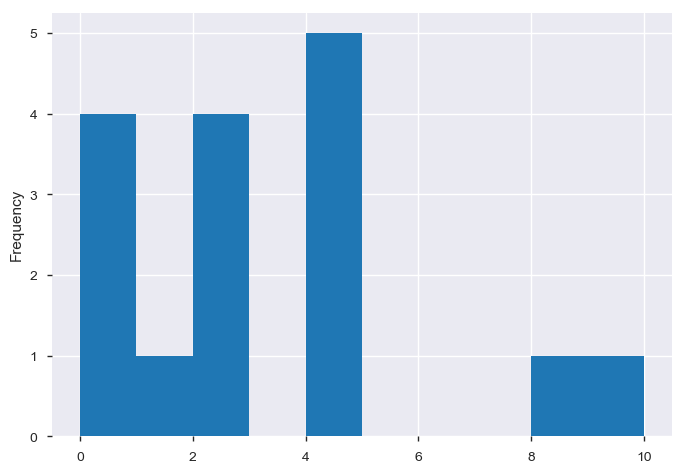

In [74]:
df['cupcakes_eaten'].plot('hist')

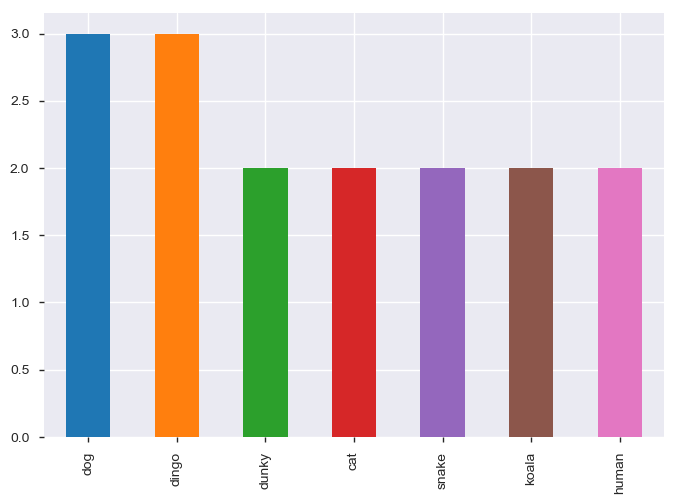

In [75]:
df['animal'].value_counts().plot('bar');

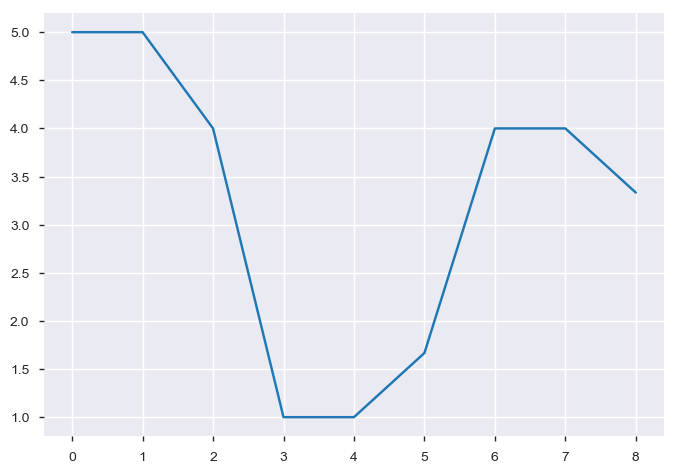

In [76]:
df_avg['avg_to_now'].plot('line')

### That's all folks!